In [7]:
import sys
import ray
import time
import math
import os


In [8]:
ray.init()

2022-07-26 23:32:35,628	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '172.28.6.160',
 'raylet_ip_address': '172.28.6.160',
 'redis_address': '172.28.6.160:6379',
 'object_store_address': '/tmp/ray/session_2022-07-26_23-32-35_146553_37707/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-07-26_23-32-35_146553_37707/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2022-07-26_23-32-35_146553_37707',
 'metrics_export_port': 60383,
 'node_id': '1586b34fa8edaba7ad876283501ca54c33f9f528'}

In [102]:
prefix = ""
@ray.remote
def launch(cc, trace, slow_unit, ack_highprio = 1, abc_dt = 64000, abc_delta = 64000, abc_token = 50, abc_eta = 0.95):
    work_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation"
    os.chdir(work_dir)
    print("python run.py --c {} --trace {}  --bw 100 --topo 2layer --hpai 80 --slow_unit {} --ack_highprio {} --abc_dt {}  --abc_delta {} --abc_token {} --abc_eta {}".format(cc, trace, slow_unit, ack_highprio, abc_dt, abc_delta, abc_token, abc_eta))
    os.system("python run.py --c {} --trace {}  --bw 100 --topo 2layer --hpai 80 --slow_unit {} --ack_highprio {} --abc_dt {}  --abc_delta {} --abc_token {} --abc_eta {}".format(cc, trace, slow_unit, ack_highprio, abc_dt, abc_delta, abc_token, abc_eta))


def gen_trafic_config(wkld, nhost, load, time_s, incast, pattern=0):
    work_dir = "/home/cxyzhao/High-Precision-Congestion-Control/traffic_gen"
    os.chdir(work_dir)
    output_name = "{}_n{}_load{}_t{}_incast{}_pattern{}".format(wkld, nhost, load, time_s, incast, pattern)
    
    #Check if requried file already exist
    dataset_files = os.listdir("/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix")
    for file in dataset_files:
         if file.find(output_name + ".txt") !=-1:
                #Already generate required files
                return output_name
            
    cmd = "python traffic_gen.py -c {}.txt -n {} -l {} -b 100G -t {} -o {}.txt -i {} -p {}".format(wkld, nhost, load, time_s, output_name, incast, pattern)
    os.system(cmd)
    mix_path =  work_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix"
    os.system("cp ./{}.txt {}".format(output_name, mix_path))
    return output_name

In [92]:
prefix = "1longflow"
lst = []
for abc_delta in [16000, 32000, 64000]:
    f_id = launch.remote("abc", prefix, slow_unit= 0, ack_highprio = 1, abc_dt = abc_delta, abc_delta = abc_delta, abc_token=50)
    lst.append(f_id)
    f_id = launch.remote("abc", prefix, slow_unit= 0, ack_highprio = 1, abc_dt = int(abc_delta / 2), abc_delta = abc_delta, abc_token=50)
    lst.append(f_id)
    f_id = launch.remote("abc", prefix, slow_unit= 0, ack_highprio = 1, abc_dt = 0, abc_delta = abc_delta, abc_token=50)
    lst.append(f_id)
    ray.wait(lst, num_returns=len(lst))  
    lst = []

(pid=38326) python run.py --c abc --trace 1longflow  --bw 100 --topo 2layer --hpai 80 --slow_unit 0 --ack_highprio 1 --abc_dt 8000  --abc_delta 16000 --abc_token 50
(pid=38354) python run.py --c abc --trace 1longflow  --bw 100 --topo 2layer --hpai 80 --slow_unit 0 --ack_highprio 1 --abc_dt 0  --abc_delta 16000 --abc_token 50
(pid=38401) python run.py --c abc --trace 1longflow  --bw 100 --topo 2layer --hpai 80 --slow_unit 0 --ack_highprio 1 --abc_dt 16000  --abc_delta 16000 --abc_token 50


(pid=38326) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38401) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38354) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38326) Waf: Leaving directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38326) 'build' finished successfully (0.380s)
(pid=38401) Waf: Leaving directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38401) 'build' finished successfully (0.382s)
(pid=38354) Waf: Leaving directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38354) 'build' finished successfully (0.386s)


(pid=38326) ENABLE_QCN			Yes
(pid=38326) USE_DYNAMIC_PFC_THRESHOLD	Yes
(pid=38326) PACKET_PAYLOAD_SIZE		1000
(pid=38326) TOPOLOGY_FILE			mix/2layer.txt
(pid=38326) FLOW_FILE			mix/1longflow.txt
(pid=38326) TRACE_FILE			mix/trace.txt
(pid=38326) TRACE_OUTPUT_FILE		mix/mix_2layer_1longflow_abcdt8000dl16000token50_1.tr
(pid=38326) FCT_OUTPUT_FILE		mix/fct_2layer_1longflow_abcdt8000dl16000token50_1.txt
(pid=38326) PFC_OUTPUT_FILE				mix/pfc_2layer_1longflow_abcdt8000dl16000token50_1.txt
(pid=38326) SIMULATOR_STOP_TIME		2.1
(pid=38326) CC_MODE		9
(pid=38326) ALPHA_RESUME_INTERVAL		1
(pid=38326) RATE_DECREASE_INTERVAL		4
(pid=38326) CLAMP_TARGET_RATE		No
(pid=38326) RP_TIMER			300
(pid=38326) EWMA_GAIN			0.00390625
(pid=38326) FAST_RECOVERY_TIMES		1
(pid=38326) RATE_AI				20Mb/s
(pid=38326) RATE_HAI			200Mb/s
(pid=38326) MIN_RATE		1000Mb/s
(pid=38326) DCTCP_RATE_AI				1000Mb/s
(pid=38326) ERROR_RATE_PER_LINK		0
(pid=38326) L2_CHUNK_SIZE			4000
(pid=38326) L2_ACK_INTERVAL			1
(pid=38326) L2_B

(pid=38326) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38401) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38354) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38326) Waf: Leaving directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38326) 'build' finished successfully (0.368s)
(pid=38401) Waf: Leaving directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38401) 'build' finished successfully (0.360s)
(pid=38354) Waf: Leaving directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38354) 'build' finished successfully (0.357s)


(pid=38326) ENABLE_QCN			Yes
(pid=38326) USE_DYNAMIC_PFC_THRESHOLD	Yes
(pid=38326) PACKET_PAYLOAD_SIZE		1000
(pid=38326) TOPOLOGY_FILE			mix/2layer.txt
(pid=38326) FLOW_FILE			mix/1longflow.txt
(pid=38326) TRACE_FILE			mix/trace.txt
(pid=38326) TRACE_OUTPUT_FILE		mix/mix_2layer_1longflow_abcdt0dl32000token50_1.tr
(pid=38326) FCT_OUTPUT_FILE		mix/fct_2layer_1longflow_abcdt0dl32000token50_1.txt
(pid=38326) PFC_OUTPUT_FILE				mix/pfc_2layer_1longflow_abcdt0dl32000token50_1.txt
(pid=38326) SIMULATOR_STOP_TIME		2.1
(pid=38326) CC_MODE		9
(pid=38326) ALPHA_RESUME_INTERVAL		1
(pid=38326) RATE_DECREASE_INTERVAL		4
(pid=38326) CLAMP_TARGET_RATE		No
(pid=38326) RP_TIMER			300
(pid=38326) EWMA_GAIN			0.00390625
(pid=38326) FAST_RECOVERY_TIMES		1
(pid=38326) RATE_AI				20Mb/s
(pid=38326) RATE_HAI			200Mb/s
(pid=38326) MIN_RATE		1000Mb/s
(pid=38326) DCTCP_RATE_AI				1000Mb/s
(pid=38326) ERROR_RATE_PER_LINK		0
(pid=38326) L2_CHUNK_SIZE			4000
(pid=38326) L2_ACK_INTERVAL			1
(pid=38326) L2_BACK_TO_ZE

(pid=38326) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38401) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38354) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38326) Waf: Leaving directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38326) 'build' finished successfully (0.361s)
(pid=38401) Waf: Leaving directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38401) 'build' finished successfully (0.363s)
(pid=38354) Waf: Leaving directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38354) 'build' finished successfully (0.364s)


(pid=38326) ENABLE_QCN			Yes
(pid=38326) USE_DYNAMIC_PFC_THRESHOLD	Yes
(pid=38326) PACKET_PAYLOAD_SIZE		1000
(pid=38326) TOPOLOGY_FILE			mix/2layer.txt
(pid=38326) FLOW_FILE			mix/1longflow.txt
(pid=38326) TRACE_FILE			mix/trace.txt
(pid=38326) TRACE_OUTPUT_FILE		mix/mix_2layer_1longflow_abcdt0dl64000token50_1.tr
(pid=38326) FCT_OUTPUT_FILE		mix/fct_2layer_1longflow_abcdt0dl64000token50_1.txt
(pid=38326) PFC_OUTPUT_FILE				mix/pfc_2layer_1longflow_abcdt0dl64000token50_1.txt
(pid=38326) SIMULATOR_STOP_TIME		2.1
(pid=38326) CC_MODE		9
(pid=38326) ALPHA_RESUME_INTERVAL		1
(pid=38326) RATE_DECREASE_INTERVAL		4
(pid=38326) CLAMP_TARGET_RATE		No
(pid=38326) RP_TIMER			300
(pid=38326) EWMA_GAIN			0.00390625
(pid=38326) FAST_RECOVERY_TIMES		1
(pid=38326) RATE_AI				20Mb/s
(pid=38326) RATE_HAI			200Mb/s
(pid=38326) MIN_RATE		1000Mb/s
(pid=38326) DCTCP_RATE_AI				1000Mb/s
(pid=38326) ERROR_RATE_PER_LINK		0
(pid=38326) L2_CHUNK_SIZE			4000
(pid=38326) L2_ACK_INTERVAL			1
(pid=38326) L2_BACK_TO_ZE

In [91]:
 f_id = launch.remote("abc", prefix, slow_unit= 0, ack_highprio = 1, abc_dt = 0, abc_delta = 16000, abc_token=50)

(pid=38401) python run.py --c abc --trace 1longflow  --bw 100 --topo 2layer --hpai 80 --slow_unit 0 --ack_highprio 1 --abc_dt 0  --abc_delta 16000 --abc_token 50


(pid=38401) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38401) [ 445/1425] install-ns3-header: src/point-to-point/model/switch-node.h -> build/ns3/switch-node.h
(pid=38401) [ 689/1425] cxx: scratch/third.cc -> build/scratch/third.cc.3.o
(pid=38401) [ 788/1425] cxx: src/point-to-point/model/switch-node.cc -> build/src/point-to-point/model/switch-node.cc.1.o
(pid=38401) [1395/1425] cxxshlib: build/src/point-to-point/model/point-to-point-net-device.cc.1.o build/src/point-to-point/model/point-to-point-channel.cc.1.o build/src/point-to-point/model/point-to-point-remote-channel.cc.1.o build/src/point-to-point/model/ppp-header.cc.1.o build/src/point-to-point/helper/point-to-point-helper.cc.1.o build/src/point-to-point/helper/qbb-helper.cc.1.o build/src/point-to-point/model/qbb-net-device.cc.1.o build/src/point-to-point/model/pause-header.cc.1.o build/src/point-to-point/model/cn-header.cc.1.o build/src/point-to-point/model/qbb-header.cc.1.o b

(pid=38401) [1406/1425] cxxshlib: build/src/olsr/model/olsr-header.cc.1.o build/src/olsr/model/olsr-state.cc.1.o build/src/olsr/model/olsr-routing-protocol.cc.1.o build/src/olsr/helper/olsr-helper.cc.1.o -> build/libns3.18-olsr-debug.so
(pid=38401) [1407/1425] cxxshlib: build/src/lte/model/lte-common.cc.1.o build/src/lte/model/lte-spectrum-phy.cc.1.o build/src/lte/model/lte-spectrum-signal-parameters.cc.1.o build/src/lte/model/lte-phy.cc.1.o build/src/lte/model/lte-enb-phy.cc.1.o build/src/lte/model/lte-ue-phy.cc.1.o build/src/lte/model/lte-spectrum-value-helper.cc.1.o build/src/lte/model/lte-amc.cc.1.o build/src/lte/model/lte-enb-rrc.cc.1.o build/src/lte/model/lte-ue-rrc.cc.1.o build/src/lte/model/lte-rlc-sap.cc.1.o build/src/lte/model/lte-rlc.cc.1.o build/src/lte/model/lte-rlc-sequence-number.cc.1.o build/src/lte/model/lte-rlc-header.cc.1.o build/src/lte/model/lte-rlc-am-header.cc.1.o build/src/lte/model/lte-rlc-um.cc.1.o build/src/lte/model/lte-rlc-am.cc.1.o build/src/lte/model/lte-

(pid=38401) ENABLE_QCN			Yes
(pid=38401) USE_DYNAMIC_PFC_THRESHOLD	Yes
(pid=38401) PACKET_PAYLOAD_SIZE		1000
(pid=38401) TOPOLOGY_FILE			mix/2layer.txt
(pid=38401) FLOW_FILE			mix/1longflow.txt
(pid=38401) TRACE_FILE			mix/trace.txt
(pid=38401) TRACE_OUTPUT_FILE		mix/mix_2layer_1longflow_abcdt0dl16000token50_1.tr
(pid=38401) FCT_OUTPUT_FILE		mix/fct_2layer_1longflow_abcdt0dl16000token50_1.txt
(pid=38401) PFC_OUTPUT_FILE				mix/pfc_2layer_1longflow_abcdt0dl16000token50_1.txt
(pid=38401) SIMULATOR_STOP_TIME		3
(pid=38401) CC_MODE		9
(pid=38401) ALPHA_RESUME_INTERVAL		1
(pid=38401) RATE_DECREASE_INTERVAL		4
(pid=38401) CLAMP_TARGET_RATE		No
(pid=38401) RP_TIMER			300
(pid=38401) EWMA_GAIN			0.00390625
(pid=38401) FAST_RECOVERY_TIMES		1
(pid=38401) RATE_AI				20Mb/s
(pid=38401) RATE_HAI			200Mb/s
(pid=38401) MIN_RATE		1000Mb/s
(pid=38401) DCTCP_RATE_AI				1000Mb/s
(pid=38401) ERROR_RATE_PER_LINK		0
(pid=38401) L2_CHUNK_SIZE			4000
(pid=38401) L2_ACK_INTERVAL			1
(pid=38401) L2_BACK_TO_ZERO

In [70]:
prefix = "1longflow"
abc_dt = 32000
abc_delta = 32000
ack = 1
lst = []
for method in ["slow", "abc", "hp", "dctcp", "timely", "dcqcn"]:
    trace = prefix
    if (method != "slow"):   
        f_id = launch.remote(method, trace, slow_unit= 0, ack_highprio = ack, abc_dt = abc_dt, abc_delta = abc_delta)
        lst.append(f_id)
    else:
        f_id = launch.remote("abc", trace, slow_unit=1, ack_highprio = ack, abc_dt = abc_dt, abc_delta = abc_delta)
        lst.append(f_id)
ray.wait(lst, num_returns=len(lst))


(pid=38421) python run.py --c abc --trace 1longflow  --bw 100 --topo 2layer --hpai 80 --slow_unit 1 --ack_highprio 1 --abc_dt 32000  --abc_delta 32000
(pid=38408) python run.py --c dctcp --trace 1longflow  --bw 100 --topo 2layer --hpai 80 --slow_unit 0 --ack_highprio 1 --abc_dt 32000  --abc_delta 32000
(pid=38377) python run.py --c hp --trace 1longflow  --bw 100 --topo 2layer --hpai 80 --slow_unit 0 --ack_highprio 1 --abc_dt 32000  --abc_delta 32000
(pid=38373) python run.py --c timely --trace 1longflow  --bw 100 --topo 2layer --hpai 80 --slow_unit 0 --ack_highprio 1 --abc_dt 32000  --abc_delta 32000
(pid=38415) python run.py --c dcqcn --trace 1longflow  --bw 100 --topo 2layer --hpai 80 --slow_unit 0 --ack_highprio 1 --abc_dt 32000  --abc_delta 32000
(pid=38404) python run.py --c abc --trace 1longflow  --bw 100 --topo 2layer --hpai 80 --slow_unit 0 --ack_highprio 1 --abc_dt 32000  --abc_delta 32000


(pid=38421) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38377) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38408) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38373) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38415) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38404) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38421) Waf: Leaving directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38421) 'build' finished successfully (0.385s)
(pid=38377) Waf: Leaving directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38377) 'build' finished successfully (0.382s)
(pid=38408) Waf: Leaving directory `/home/cxyzhao/High-Precision-Congestion-

(pid=38421) ENABLE_QCN			Yes
(pid=38421) USE_DYNAMIC_PFC_THRESHOLD	Yes
(pid=38421) PACKET_PAYLOAD_SIZE		1000
(pid=38421) TOPOLOGY_FILE			mix/2layer.txt
(pid=38421) FLOW_FILE			mix/1longflow.txt
(pid=38421) TRACE_FILE			mix/trace.txt
(pid=38421) TRACE_OUTPUT_FILE		mix/mix_2layer_1longflow_abc_slowUnitdt32000dl32000_1.tr
(pid=38421) FCT_OUTPUT_FILE		mix/fct_2layer_1longflow_abc_slowUnitdt32000dl32000_1.txt
(pid=38421) PFC_OUTPUT_FILE				mix/pfc_2layer_1longflow_abc_slowUnitdt32000dl32000_1.txt
(pid=38421) SIMULATOR_STOP_TIME		2.1
(pid=38421) CC_MODE		9
(pid=38421) ALPHA_RESUME_INTERVAL		1
(pid=38421) RATE_DECREASE_INTERVAL		4
(pid=38421) CLAMP_TARGET_RATE		No
(pid=38421) RP_TIMER			300
(pid=38421) EWMA_GAIN			0.00390625
(pid=38421) FAST_RECOVERY_TIMES		1
(pid=38421) RATE_AI				20Mb/s
(pid=38421) RATE_HAI			200Mb/s
(pid=38421) MIN_RATE		1000Mb/s
(pid=38421) DCTCP_RATE_AI				1000Mb/s
(pid=38421) ERROR_RATE_PER_LINK		0
(pid=38421) L2_CHUNK_SIZE			4000
(pid=38421) L2_ACK_INTERVAL			1
(pid=38

(pid=38421) maxRtt=8320 maxBdp=104000
(pid=38421) Running Simulation.
(pid=38408) maxRtt=8320 maxBdp=104000
(pid=38408) Running Simulation.
(pid=38377) maxRtt=8320 maxBdp=104000
(pid=38377) Running Simulation.
(pid=38373) maxRtt=8320 maxBdp=104000
(pid=38373) Running Simulation.
(pid=38415) maxRtt=8320 maxBdp=104000
(pid=38415) Running Simulation.
(pid=38404) maxRtt=8320 maxBdp=104000
(pid=38404) Running Simulation.
(pid=38408) 226.791
(pid=38373) 240.714
(pid=38377) 243.701
(pid=38404) 244.125
(pid=38421) 249.58
(pid=38415) 265.745
without incast: 70443
with incast: 70443
(pid=38421) python run.py --c abc --trace WebSearch_distribution_n64_load0.3_t0.5_incast0_pattern0  --bw 100 --topo 2layer --hpai 80 --slow_unit 0 --ack_highprio 1 --abc_dt 32000  --abc_delta 32000
(pid=38408) python run.py --c dcqcn --trace WebSearch_distribution_n64_load0.3_t0.5_incast0_pattern0  --bw 100 --topo 2layer --hpai 80 --slow_unit 0 --ack_highprio 1 --abc_dt 32000  --abc_delta 32000
(pid=38377) python run

(pid=38421) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38377) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38408) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38415) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38373) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38404) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38421) Waf: Leaving directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38421) 'build' finished successfully (0.362s)
(pid=38377) Waf: Leaving directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38377) 'build' finished successfully (0.365s)
(pid=38408) Waf: Leaving directory `/home/cxyzhao/High-Precision-Congestion-

(pid=38421) ENABLE_QCN			Yes
(pid=38421) USE_DYNAMIC_PFC_THRESHOLD	Yes
(pid=38421) PACKET_PAYLOAD_SIZE		1000
(pid=38421) TOPOLOGY_FILE			mix/2layer.txt
(pid=38421) FLOW_FILE			mix/WebSearch_distribution_n64_load0.3_t0.5_incast0_pattern0.txt
(pid=38421) TRACE_FILE			mix/trace.txt
(pid=38421) TRACE_OUTPUT_FILE		mix/mix_2layer_WebSearch_distribution_n64_load0.3_t0.5_incast0_pattern0_abcdt32000dl32000_1.tr
(pid=38421) FCT_OUTPUT_FILE		mix/fct_2layer_WebSearch_distribution_n64_load0.3_t0.5_incast0_pattern0_abcdt32000dl32000_1.txt
(pid=38421) PFC_OUTPUT_FILE				mix/pfc_2layer_WebSearch_distribution_n64_load0.3_t0.5_incast0_pattern0_abcdt32000dl32000_1.txt
(pid=38421) SIMULATOR_STOP_TIME		2.1
(pid=38421) CC_MODE		9
(pid=38421) ALPHA_RESUME_INTERVAL		1
(pid=38421) RATE_DECREASE_INTERVAL		4
(pid=38421) CLAMP_TARGET_RATE		No
(pid=38421) RP_TIMER			300
(pid=38421) EWMA_GAIN			0.00390625
(pid=38421) FAST_RECOVERY_TIMES		1
(pid=38421) RATE_AI				20Mb/s
(pid=38421) RATE_HAI			200Mb/s
(pid=38421) MIN

(pid=38377) maxRtt=8320 maxBdp=104000
(pid=38377) Running Simulation.
(pid=38408) maxRtt=8320 maxBdp=104000
(pid=38408) Running Simulation.
(pid=38415) maxRtt=8320 maxBdp=104000
(pid=38415) Running Simulation.
(pid=38421) maxRtt=8320 maxBdp=104000
(pid=38421) Running Simulation.
(pid=38373) maxRtt=8320 maxBdp=104000
(pid=38373) Running Simulation.
(pid=38404) maxRtt=8320 maxBdp=104000
(pid=38404) Running Simulation.


KeyboardInterrupt: 

In [ ]:
lst = []
for wkld in ["FbHdp_distribution"]:
    for load in [0.6]:
        for p in [0]:
            prefix = gen_trafic_config(wkld=wkld, nhost=64, load=load, time_s=0.1, incast=0, pattern=p)
            for abc_eta in [0.85]:
                for abc_token in [50]:
                    for abc_delta in [6000]:
                        for abc_dt_ratio in [0]:
                            abc_dt = abc_dt_ratio * abc_delta
                            for method in ["abc"]:
                                trace = prefix
                                if (method != "slow"):   
                                    f_id = launch.remote(method, trace, slow_unit= 0, ack_highprio = ack, abc_dt = abc_dt, abc_delta = abc_delta, abc_token = abc_token, abc_eta=abc_eta)
                                    lst.append(f_id)
                                else:
                                    f_id = launch.remote("abc", trace, slow_unit=1, ack_highprio = ack, abc_dt = abc_dt, abc_delta = abc_delta, abc_token = abc_token, abc_eta=abc_eta)
                                    lst.append(f_id)
    ray.wait(lst, num_returns=len(lst))
    lst = []
            
# for wkld in ["WebSearch_distribution", "FbHdp_distribution"]:
#     for load in [0.3]:
#         for p in [0]:
#             prefix = gen_trafic_config(wkld=wkld, nhost=64, load=load, time_s=0.05, incast=1, pattern=p)
#             lst = []
#             for method in ["slow", "abc", "hp", "dctcp", "timely", "dcqcn"]:
#                 trace = prefix
#                 if (method != "slow"):   
#                     f_id = launch.remote(method, trace, slow_unit= 0, ack_highprio = ack, abc_dt = abc_dt, abc_delta = abc_delta)
#                     lst.append(f_id)
#                 else:
#                     f_id = launch.remote("abc", trace, slow_unit=1, ack_highprio = ack, abc_dt = abc_dt, abc_delta = abc_delta)
#                     lst.append(f_id)
#             #ray.wait(lst, num_returns=len(lst))


without incast: 398680
with incast: 398680
(pid=38332) python run.py --c abc --trace FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0  --bw 100 --topo 2layer --hpai 80 --slow_unit 0 --ack_highprio 1 --abc_dt 0  --abc_delta 6000 --abc_token 50 --abc_eta 0.85


(pid=38332) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38332) Waf: Leaving directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38332) 'build' finished successfully (0.378s)


(pid=38332) ENABLE_QCN			Yes
(pid=38332) USE_DYNAMIC_PFC_THRESHOLD	Yes
(pid=38332) PACKET_PAYLOAD_SIZE		1000
(pid=38332) TOPOLOGY_FILE			mix/2layer.txt
(pid=38332) FLOW_FILE			mix/FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0.txt
(pid=38332) TRACE_FILE			mix/trace.txt
(pid=38332) TRACE_OUTPUT_FILE		mix/mix_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_abcdt0.0dl6000.0token50eta0.85_1.tr
(pid=38332) FCT_OUTPUT_FILE		mix/fct_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_abcdt0.0dl6000.0token50eta0.85_1.txt
(pid=38332) PFC_OUTPUT_FILE				mix/pfc_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_abcdt0.0dl6000.0token50eta0.85_1.txt
(pid=38332) SIMULATOR_STOP_TIME		2.1
(pid=38332) CC_MODE		9
(pid=38332) ALPHA_RESUME_INTERVAL		1
(pid=38332) RATE_DECREASE_INTERVAL		4
(pid=38332) CLAMP_TARGET_RATE		No
(pid=38332) RP_TIMER			300
(pid=38332) EWMA_GAIN			0.00390625
(pid=38332) FAST_RECOVERY_TIMES		1
(pid=38332) RATE_AI				20Mb/s
(pid=38332) RATE_HAI			

In [ ]:
lst = []
for wkld in ["FbHdp_distribution"]:
    for load in [0.6]:
        for p in [0]:
            prefix = gen_trafic_config(wkld=wkld, nhost=64, load=load, time_s=0.1, incast=0, pattern=p)
            for abc_eta in [0.95]:
                for abc_token in [50]:
                    for abc_delta in [16000]:
                        for abc_dt_ratio in [0]:
                            abc_dt = abc_dt_ratio * abc_delta
                            for method in ["aabc"]:
                                trace = prefix
                                if (method != "slow"):   
                                    f_id = launch.remote(method, trace, slow_unit= 0, ack_highprio = ack, abc_dt = abc_dt, abc_delta = abc_delta, abc_token = abc_token, abc_eta=abc_eta)
                                    lst.append(f_id)
                                else:
                                    f_id = launch.remote("abc", trace, slow_unit=1, ack_highprio = ack, abc_dt = abc_dt, abc_delta = abc_delta, abc_token = abc_token, abc_eta=abc_eta)
                                    lst.append(f_id)
            ray.wait(lst, num_returns=len(lst))
            lst = []

(0, 2000000000.0, 0)
without incast: 398015
with incast: 398015
(pid=38401) python run.py --c aabc --trace FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0  --bw 100 --topo 2layer --hpai 80 --slow_unit 0 --ack_highprio 1 --abc_dt 0  --abc_delta 16000 --abc_token 50 --abc_eta 0.95


(pid=38401) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38401) Waf: Leaving directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38401) 'build' finished successfully (0.381s)


(pid=38401) ENABLE_QCN			Yes
(pid=38401) USE_DYNAMIC_PFC_THRESHOLD	Yes
(pid=38401) PACKET_PAYLOAD_SIZE		1000
(pid=38401) TOPOLOGY_FILE			mix/2layer.txt
(pid=38401) FLOW_FILE			mix/FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0.txt
(pid=38401) TRACE_FILE			mix/trace.txt
(pid=38401) TRACE_OUTPUT_FILE		mix/mix_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_aabcdt0.0dl16000.0token50eta0.95.tr
(pid=38401) FCT_OUTPUT_FILE		mix/fct_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_aabcdt0.0dl16000.0token50eta0.95.txt
(pid=38401) PFC_OUTPUT_FILE				mix/pfc_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_aabcdt0.0dl16000.0token50eta0.95.txt
(pid=38401) SIMULATOR_STOP_TIME		2.1
(pid=38401) CC_MODE		5
(pid=38401) ALPHA_RESUME_INTERVAL		1
(pid=38401) RATE_DECREASE_INTERVAL		4
(pid=38401) CLAMP_TARGET_RATE		No
(pid=38401) RP_TIMER			300
(pid=38401) EWMA_GAIN			0.00390625
(pid=38401) FAST_RECOVERY_TIMES		1
(pid=38401) RATE_AI				20M

In [100]:
lst = []
for wkld in ["FbHdp_distribution"]:
    for load in [0.3, 0.6]:
        for p in [0]:
            prefix = gen_trafic_config(wkld=wkld, nhost=64, load=load, time_s=0.04, incast=0, pattern=p)
            
            for abc_token in [30, 50, 70]:
                for abc_delta in [16000, 32000, 64000]:
                    for abc_dt_ratio in [0, 0.5, 1]:
                        abc_dt = abc_dt_ratio * abc_delta
                        if (abc_dt == 0 and abc_delta==16000):
                            continue
                        for method in ["abc"]:
                            trace = prefix
                            if (method != "slow"):   
                                f_id = launch.remote(method, trace, slow_unit= 0, ack_highprio = ack, abc_dt = abc_dt, abc_delta = abc_delta, abc_token = abc_token)
                                lst.append(f_id)
                            else:
                                f_id = launch.remote("abc", trace, slow_unit=1, ack_highprio = ack, abc_dt = abc_dt, abc_delta = abc_delta, abc_token = abc_token)
                                lst.append(f_id)
                ray.wait(lst, num_returns=len(lst))
                lst = []

SyntaxError: invalid syntax (800792279.py, line 11)

In [115]:
for abc_eta in [0.85, 0.9, 0.95]:
            for abc_token in [50]:
                for abc_delta in [16000.0]:
                    for abc_dt_ratio in [0.0]:
                        abc_dt = abc_dt_ratio * abc_delta
                        print("\"abcdt{}dl{}token{}eta{}_1\",".format(abc_dt, abc_delta, abc_token, abc_eta))

"abcdt0.0dl16000.0token50eta0.85_1",
"abcdt0.0dl16000.0token50eta0.9_1",
"abcdt0.0dl16000.0token50eta0.95_1",


In [319]:
trace = "FbHdp_distribution_n16_load0.6_t0.005_inject1_repeat3"

f_id = launch.remote("aabc", trace, slow_unit=0, ack_highprio = 1, abc_dt=0, abc_delta=16000, abc_token=50)
                       

(pid=38401) python run.py --c aabc --trace FbHdp_distribution_n16_load0.6_t0.005_inject1_repeat3  --bw 100 --topo 2layer --hpai 80 --slow_unit 0 --ack_highprio 1 --abc_dt 0  --abc_delta 16000 --abc_token 50 --abc_eta 0.95


(pid=38401) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38401) [ 780/1425] cxx: src/point-to-point/model/rdma-hw.cc -> build/src/point-to-point/model/rdma-hw.cc.1.o
(pid=38401) [1233/1425] cxx: src/point-to-point/model/switch-node.cc -> build/src/point-to-point/model/switch-node.cc.1.o
(pid=38401) [1375/1425] cxxshlib: build/src/point-to-point/model/point-to-point-net-device.cc.1.o build/src/point-to-point/model/point-to-point-channel.cc.1.o build/src/point-to-point/model/point-to-point-remote-channel.cc.1.o build/src/point-to-point/model/ppp-header.cc.1.o build/src/point-to-point/helper/point-to-point-helper.cc.1.o build/src/point-to-point/helper/qbb-helper.cc.1.o build/src/point-to-point/model/qbb-net-device.cc.1.o build/src/point-to-point/model/pause-header.cc.1.o build/src/point-to-point/model/cn-header.cc.1.o build/src/point-to-point/model/qbb-header.cc.1.o build/src/point-to-point/model/qbb-channel.cc.1.o build/src/point-to-poin

(pid=38401) [1406/1425] cxxshlib: build/src/olsr/model/olsr-header.cc.1.o build/src/olsr/model/olsr-state.cc.1.o build/src/olsr/model/olsr-routing-protocol.cc.1.o build/src/olsr/helper/olsr-helper.cc.1.o -> build/libns3.18-olsr-debug.so
(pid=38401) [1407/1425] cxxshlib: build/src/lte/model/lte-common.cc.1.o build/src/lte/model/lte-spectrum-phy.cc.1.o build/src/lte/model/lte-spectrum-signal-parameters.cc.1.o build/src/lte/model/lte-phy.cc.1.o build/src/lte/model/lte-enb-phy.cc.1.o build/src/lte/model/lte-ue-phy.cc.1.o build/src/lte/model/lte-spectrum-value-helper.cc.1.o build/src/lte/model/lte-amc.cc.1.o build/src/lte/model/lte-enb-rrc.cc.1.o build/src/lte/model/lte-ue-rrc.cc.1.o build/src/lte/model/lte-rlc-sap.cc.1.o build/src/lte/model/lte-rlc.cc.1.o build/src/lte/model/lte-rlc-sequence-number.cc.1.o build/src/lte/model/lte-rlc-header.cc.1.o build/src/lte/model/lte-rlc-am-header.cc.1.o build/src/lte/model/lte-rlc-um.cc.1.o build/src/lte/model/lte-rlc-am.cc.1.o build/src/lte/model/lte-

(pid=38401) ENABLE_QCN			Yes
(pid=38401) USE_DYNAMIC_PFC_THRESHOLD	Yes
(pid=38401) PACKET_PAYLOAD_SIZE		1000
(pid=38401) TOPOLOGY_FILE			mix/2layer.txt
(pid=38401) FLOW_FILE			mix/FbHdp_distribution_n16_load0.6_t0.005_inject1_repeat3.txt
(pid=38401) TRACE_FILE			mix/trace.txt
(pid=38401) TRACE_OUTPUT_FILE		mix/mix_2layer_FbHdp_distribution_n16_load0.6_t0.005_inject1_repeat3_ackHigh1_aabcdt0.0dl16000.0token50eta0.95.tr
(pid=38401) FCT_OUTPUT_FILE		mix/fct_2layer_FbHdp_distribution_n16_load0.6_t0.005_inject1_repeat3_ackHigh1_aabcdt0.0dl16000.0token50eta0.95.txt
(pid=38401) PFC_OUTPUT_FILE				mix/pfc_2layer_FbHdp_distribution_n16_load0.6_t0.005_inject1_repeat3_ackHigh1_aabcdt0.0dl16000.0token50eta0.95.txt
(pid=38401) SIMULATOR_STOP_TIME		2.1
(pid=38401) CC_MODE		5
(pid=38401) ALPHA_RESUME_INTERVAL		1
(pid=38401) RATE_DECREASE_INTERVAL		4
(pid=38401) CLAMP_TARGET_RATE		No
(pid=38401) RP_TIMER			300
(pid=38401) EWMA_GAIN			0.00390625
(pid=38401) FAST_RECOVERY_TIMES		1
(pid=38401) RATE_AI			

/home/cxyzhao/.local/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


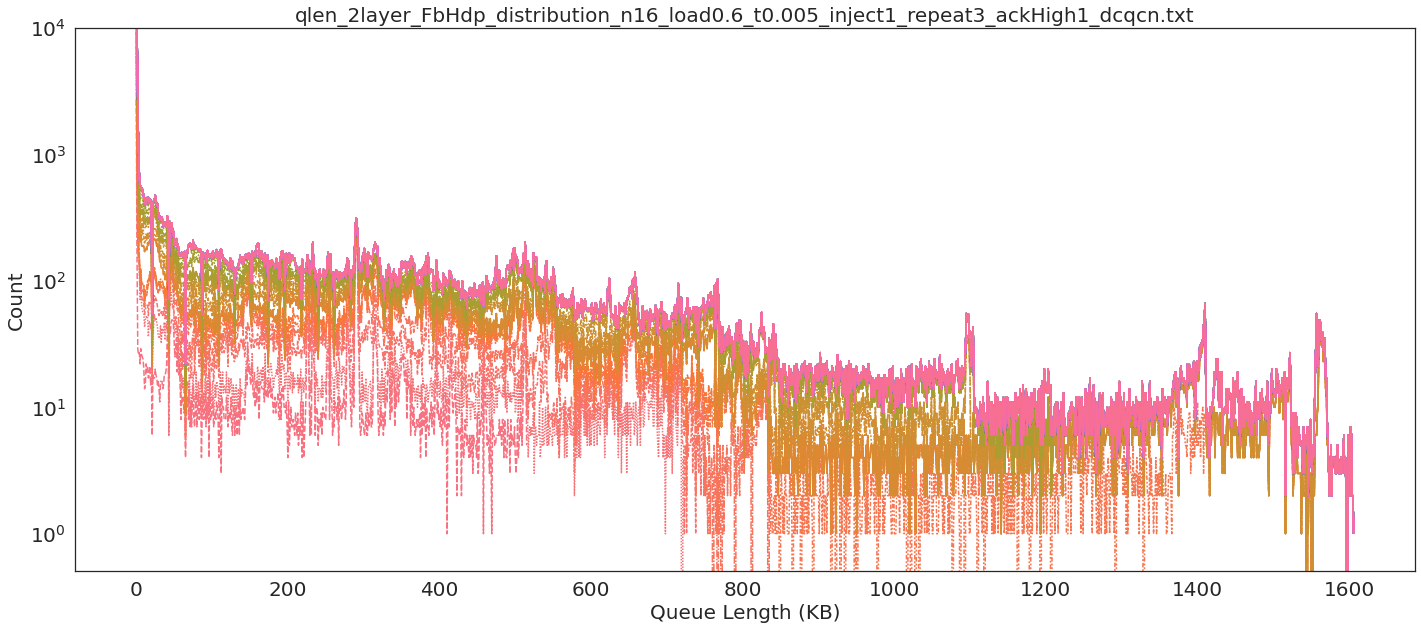

In [329]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

qlen_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix/"
#qlen_name = "qlen_2layer_FbHdp_distribution_n16_load0.6_t0.005_inject1_repeat3_ackHigh1_hp95ai80.txt"
qlen_name = "qlen_2layer_FbHdp_distribution_n16_load0.6_t0.005_inject1_repeat3_ackHigh1_dcqcn.txt"
#qlen_name = "qlen_2layer_FbHdp_distribution_n16_load0.6_t0.005_inject1_repeat3_ackHigh1_aabcdt0.0dl16000.0token50eta0.95.txt"
qlen_file = qlen_dir + qlen_name
port_to_qlenDist = {}
with open(qlen_file) as f:
    lines =f.readlines()
    for line in lines:
        if line.find("time") != -1:
            continue
        else:
            lst = line.split()
            lst = [int(i) for i in lst]
            name = "switch{}port{}".format(lst[0], lst[1])
            if name not in port_to_qlenDist.keys():
                port_to_qlenDist[name] = []
            port_to_qlenDist[name].append(lst[2:])


sns.set(rc={'figure.figsize':(24,10)})
sns.set_style('white')

#g.set_yticks([5000 * (i+1) for i in range(8)])

#g.set_yticklabels(g.get_yticks(), size=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
df = pd.DataFrame(port_to_qlenDist["switch64port2"]).T
g= sns.lineplot(data=df)
g.set_title(qlen_name, fontsize = 20)
g.set_yscale('log')
g.set_xlabel("Queue Length (KB)", fontsize = 20)
g.set_ylabel("Count", fontsize = 20)
g.set(ylim=(0, 10000))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend([],[], frameon=False)


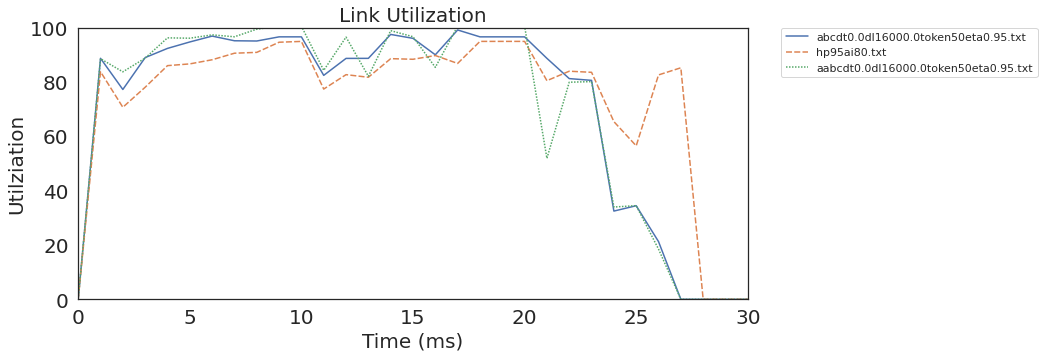

(pid=38401) 170.771


In [327]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

link_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix/"
#link_name = "link_2layer_FbHdp_distribution_n16_load0.6_t0.005_inject1_repeat3_ackHigh1_hp95ai80.txt"

link_name_lst = ["link_2layer_FbHdp_distribution_n16_load0.6_t0.005_inject1_repeat3_ackHigh1_abcdt0.0dl16000.0token50eta0.95.txt",
                "link_2layer_FbHdp_distribution_n16_load0.6_t0.005_inject1_repeat3_ackHigh1_hp95ai80.txt",
                "link_2layer_FbHdp_distribution_n16_load0.6_t0.005_inject1_repeat3_ackHigh1_aabcdt0.0dl16000.0token50eta0.95.txt"]
df =pd.DataFrame()

for link_name in link_name_lst:
    link_file = link_dir + link_name
    cc_name  = link_name[75:]
    port_to_linkutil_series = {}
    with open(link_file) as f:
        lines =f.readlines()
        for line in lines:
            if line.find("time") != -1:
                continue
            else:
                lst = line.split()
                lst = [float(i) for i in lst]
                name = "switch{}port{}".format(int(lst[0]), int(lst[1]))
                if name not in port_to_linkutil_series.keys():
                    port_to_linkutil_series[name] = []
                port_to_linkutil_series[name].append(lst[2])



    df = pd.concat([df, pd.DataFrame(port_to_linkutil_series["switch64port2"], columns=[cc_name]) ], axis=1)




sns.set(rc={'figure.figsize':(12,5)})
sns.set_style('white')

#g.set_yticks([5000 * (i+1) for i in range(8)])

#g.set_yticklabels(g.get_yticks(), size=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
g= sns.lineplot(data=df)
g.set_title("Link Utilization", fontsize = 20)
g.set_xlabel("Time (ms)", fontsize = 20)
g.set_ylabel("Utilziation", fontsize = 20)
g.set(ylim=(0, 100))
g.set(xlim=(0, 30))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.legend([],[], frameon=False)



In [245]:
df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.0,39.0,41.0,41.0,41.0,41.0,41.0,60.0,160.0,260.0,...,73820.0,74820.0,75820.0,76820.0,77820.0,78820.0,79820.0,80820.0,81820.0,82820.0
1,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
3,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0
4,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0
105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0, 0.5, 'Count')

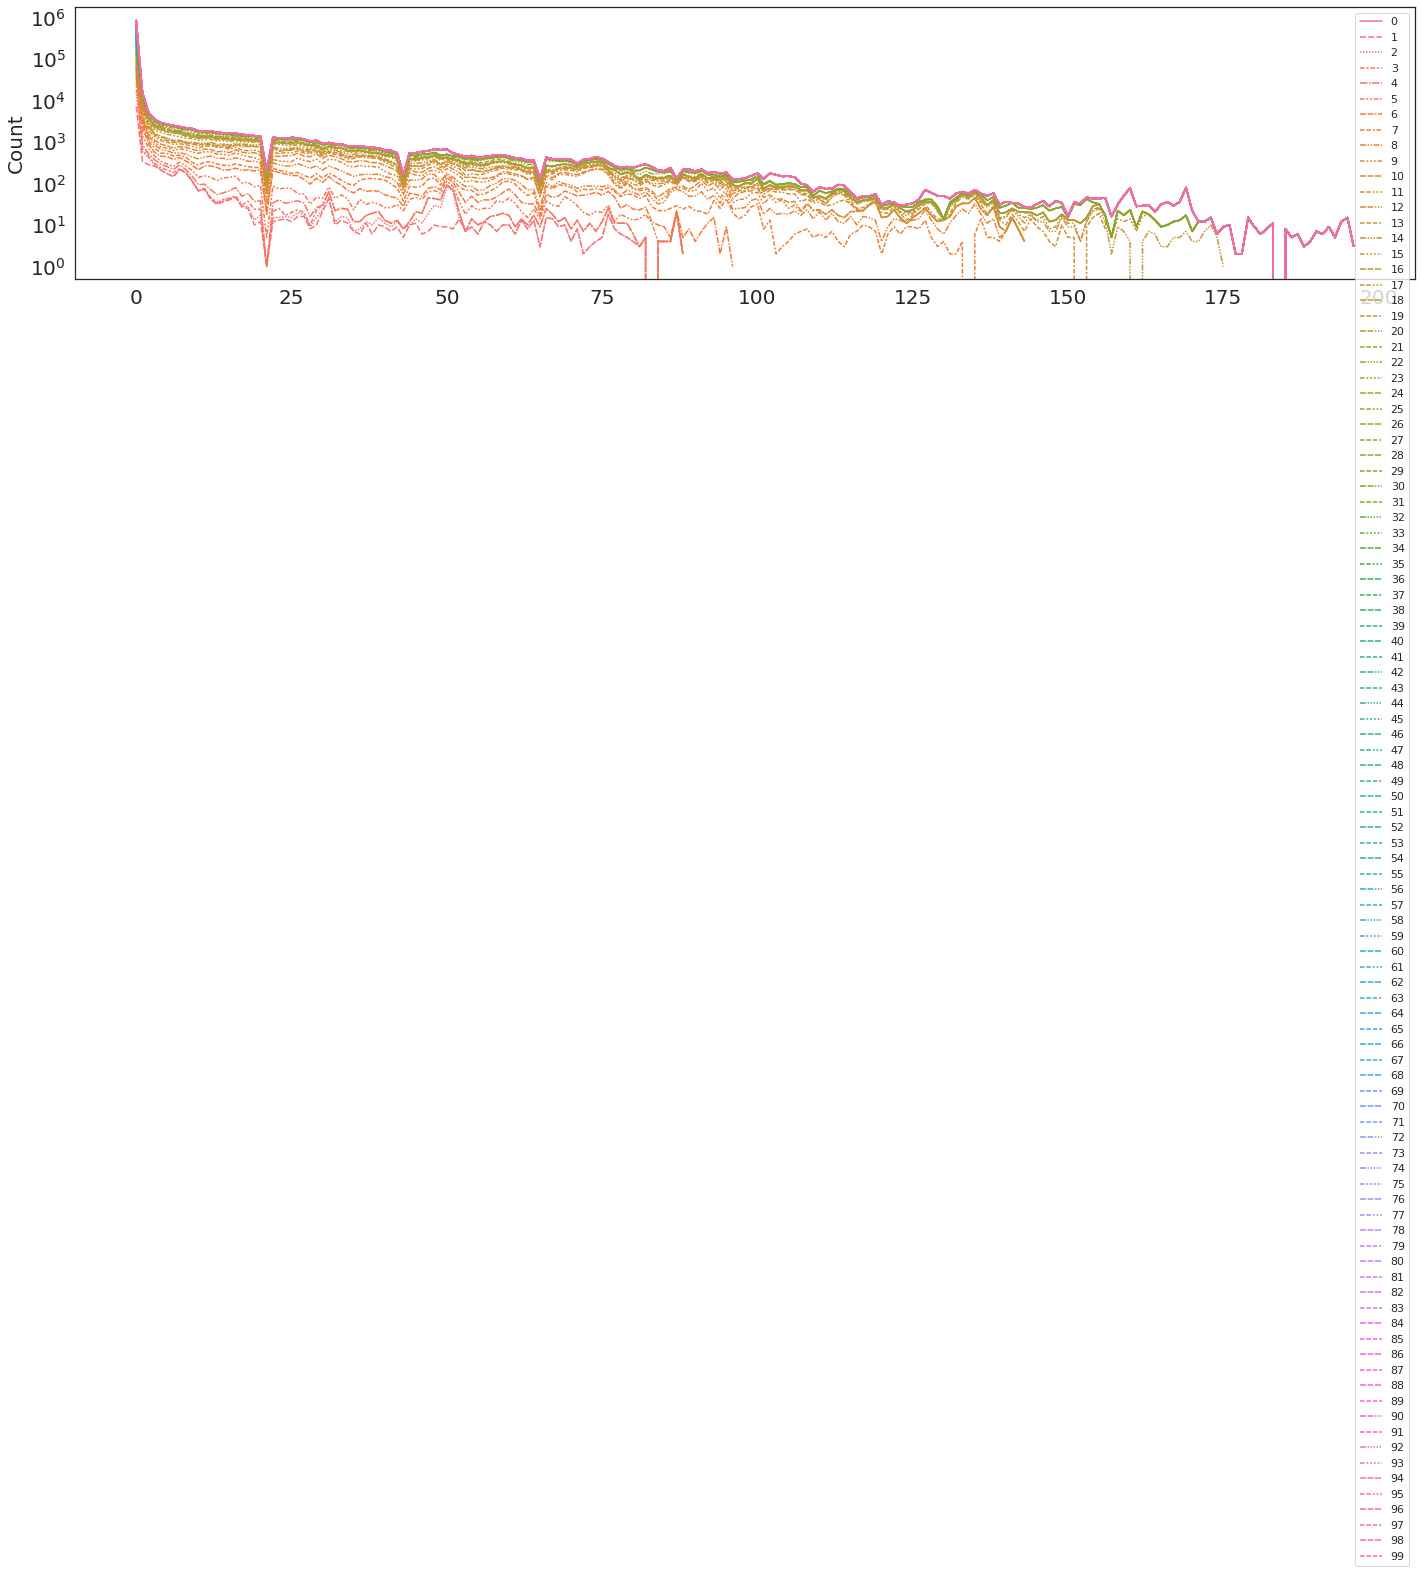

In [195]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

qlen_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix/"
port_to_qlenDist = {}
with open("/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix/qlen_2layer_1longflow_abcdt0.0dl16000.0token50eta0.95_1.txt") as f:
    lines =f.readlines()
    for line in lines:
        if line.find("time") != -1:
            continue
        else:
            lst = line.split()
            lst = [int(i) for i in lst]
            name = "switch{}port{}".format(lst[0], lst[1])
            if name not in port_to_qlenDist.keys():
                port_to_qlenDist[name] = []
            port_to_qlenDist[name].append(lst[2:])


sns.set(rc={'figure.figsize':(24,5)})
sns.set_style('white')

#g.set_yticks([5000 * (i+1) for i in range(8)])
#g.set_xlabel("Timeline", fontsize = 20)
#g.set_yticklabels(g.get_yticks(), size=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
df = pd.DataFrame(port_to_qlenDist["switch64port1"]).T
g= sns.lineplot(data=df)
g.set_yscale('log')
g.set_ylabel("Count", fontsize = 20)
